In [71]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [72]:
BASE_PATH = "/home/amiya/Desktop/Homework/pattern/pattern/license"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "IndianNumberPlates"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "indian_license_plates.csv"])

BASE_OUTPUT = "/home/amiya/Desktop/Homework/pattern/pattern/license/output"
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

In [73]:
from tensorflow import keras

model = keras.models.load_model('/home/amiya/Desktop/Homework/pattern/pattern/license/output/detector.h5', 
                                compile=False)

In [74]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import os
import glob
import pandas as pd

image_path = '/home/amiya/Desktop/Homework/pattern/pattern/license/IndianNumberPlates'
Paths = '/home/amiya/Desktop/Homework/pattern/pattern/license/output/test_images.txt'
filenames = open(Paths).read().strip().split("\n")
imagePaths = []

for f in filenames:
    p = os.path.sep.join([image_path, f])
    imagePaths.append(p)

print("[INFO] loading object detector...")

Dir = '/home/amiya/Desktop/Homework/pattern/pattern/license/output' 

data = []
for imagePath in imagePaths:

    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    base = os.path.basename(imagePath)
    (startX, startY, endX, endY) = preds

    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    value = {'filename':base,
           'XMin':startX,
           'YMin':startY,
           'XMax':endX,
           'YMax':endX,}
    data.append(value)
    image2 = cv2.rectangle(image, (startX, startY), (endX, endY),
                           (0, 255, 0), 2)

    cv2.imwrite(os.path.join(Dir,os.path.basename(imagePath)),image2)
    
print("Detection Complete")
df = pd.DataFrame(data)
df.to_csv('plate.csv')

[INFO] loading object detector...
Detection Complete


In [75]:
plate_detection = pd.read_csv('plate.csv')
selected_plate = plate_detection.loc[df['filename']=='licensed_car211.jpeg']
print(selected_plate)
name = selected_plate.iloc[0][1]
print(name)

   Unnamed: 0              filename  XMin  YMin  XMax  YMax
2           2  licensed_car211.jpeg   181   115   453   453
licensed_car211.jpeg


In [76]:
x = selected_plate.iloc[0]['XMax']
y = selected_plate.iloc[0]['YMax']
w = selected_plate.iloc[0]['YMin']
h = selected_plate.iloc[0]['XMin']
print(x,y,w,h)

453 453 115 181


In [108]:
def detect_plate(img, text=''): 
    plate_img = img.copy()
    roi = img.copy()
    #print(roi.shape)
    plate_img = np.array(plate_img,dtype='uint8')
    x = selected_plate.iloc[0]['XMin']
    y = selected_plate.iloc[0]['YMin']
    x_max = selected_plate.iloc[0]['XMax']
    y_max = selected_plate.iloc[0]['YMax']
    h = x_max - x
    w = y_max - y
    x = x-30
    y = y-20
    h = h+110
    w = w-190
    #print(x,y,w,h)
    plate_rect = np.array([[x,y,w,h]])
    print(plate_rect)
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+50, x:x+230, :]
        plate = roi[y:y+50, x:x+230, :]
        cv2.rectangle(plate_img, (x,y), (h,w), (51,181,155), 3) 
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-30,y-10),cv2.FONT_HERSHEY_COMPLEX_SMALL , 1, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate1 # returning the processed image.

In [109]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

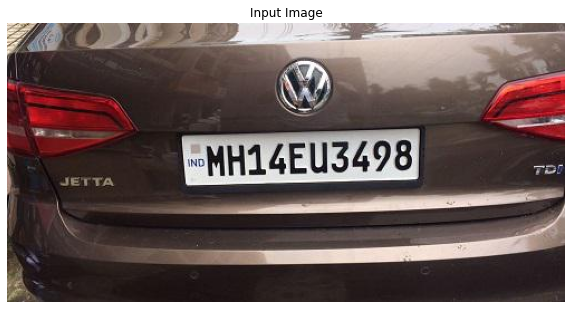

[[151  95 148 382]]


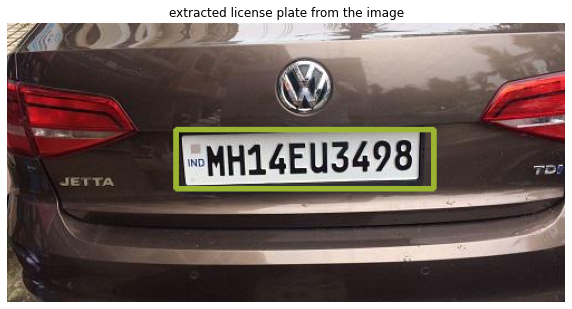

In [110]:
img = cv2.imread(os.path.join(IMAGES_PATH, name))
display (img, 'Input Image')
output_img, plate = detect_plate(img)
display(output_img, 'extracted license plate from the image')

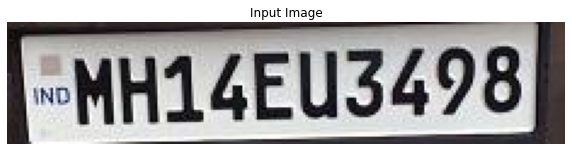

In [111]:
display (plate, 'Input Image')

In [112]:
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)
            
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

In [113]:
def segment_characters(image) :
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

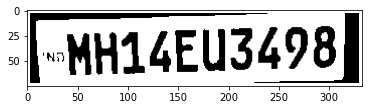

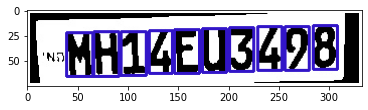

In [114]:
char = segment_characters(plate)

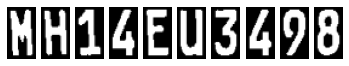

In [115]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [116]:
from tensorflow import keras

model2 = keras.models.load_model("pattern_model.h5", compile=False)

In [117]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model2.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

HH14EU3498


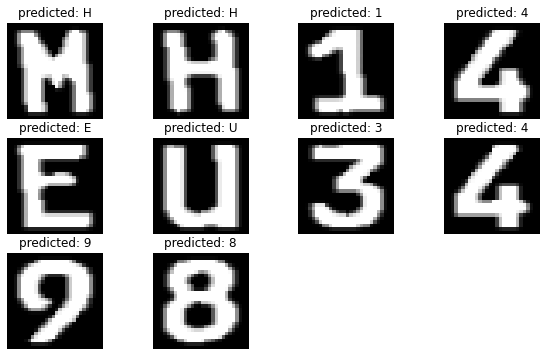

In [118]:
# Segmented characters and their predicted value.

plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img1 = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img1,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

[[151  95 148 382]]


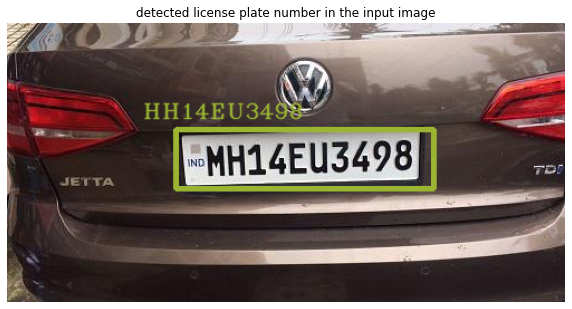

In [119]:
plate_number = show_results()
output_img, plate = detect_plate(img, plate_number)
display(output_img, 'detected license plate number in the input image')